### Imports

In [1]:
import os
import numpy as np
import gym
import random
from pyglet.window import key

### Load imitations

In [2]:
def load_imitations(data_folder):
    """
    1.1 a)
    Given the folder containing the expert imitations, the data gets loaded and
    stored it in two lists: observations and actions.
                    N = number of (observation, action) - pairs
    data_folder:    python string, the path to the folder containing the
                    observation_%05d.npy and action_%05d.npy files
    return:
    observations:   python list of N numpy.ndarrays of size (96, 96, 3)
    actions:        python list of N numpy.ndarrays of size 3
    """
    observations = []
    actions = []
    
    # List all files in the data folder
    files = sorted(os.listdir(data_folder))
    
    for file in files:
        # Check if the file is an observation or action file
        if file.startswith("observation_"):
            obs_path = os.path.join(data_folder, file)
            observations.append(np.load(obs_path))
        elif file.startswith("action_"):
            action_path = os.path.join(data_folder, file)
            actions.append(np.load(action_path))
    
    return observations, actions

In [39]:
def test_load_imitations():
    data_folder = './data/teacher'  
    observations, actions = load_imitations(data_folder)
    print(len(observations), len(actions))
    print(observations[0].shape, actions[0].shape)
    print(observations[0][0,0,0], actions[0][0])
    # print the types for the data
    print(type(observations), type(actions))
    # now check if the value of action is [0.0, 0.0, 0.0]
    if np.all(actions[0] == np.array([0.0, 0.0, 0.0])):
        print("The value of action is [0.0, 0.0, 0.0]")

test_load_imitations()

1899 1958
(96, 96, 3) (3,)
102 -0.047577157616615295
<class 'list'> <class 'list'>


### Save imitations

In [3]:
def save_imitations(data_folder, actions, observations):
    """
    1.1 f)
    Save the lists actions and observations in numpy .npy files that can be read
    by the function load_imitations.
                    N = number of (observation, action) - pairs
    data_folder:    python string, the path to the folder containing the
                    observation_%05d.npy and action_%05d.npy files
    observations:   python list of N numpy.ndarrays of size (96, 96, 3)
    actions:        python list of N numpy.ndarrays of size 3
    """
    #pass
    # Ensure the directory exists
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    # Save each observation and action pair
    for idx, (obs, act) in enumerate(zip(observations, actions)):
        obs_filename = os.path.join(data_folder, f'observation_{idx:05d}.npy')
        act_filename = os.path.join(data_folder, f'action_{idx:05d}.npy')
        
        np.save(obs_filename, obs)
        np.save(act_filename, act)

### Dataset ballancing tasks

Count the number of various possible actions within the dataset

In [4]:
def count_actions(actions):
    """
    Count the occurrences of each unique action in the provided list.
    actions:        python list of N numpy.ndarrays of size 3
    return:         dictionary with action tuples as keys and counts as values
    """
    # Define the possible actions
    possible_actions = [
        (-0.8, 0.0, 0.0),  # Steer left
        (0.8, 0.0, 0.0),   # Steer right
        (0.0, 0.4, 0.0),   # Accelerate
        (0.0, 0.0, 0.8),   # Brake
        (0.0, 0.0, 0.0),   # No action
        (-0.8, 0.4, 0.0),  # Steer left and accelerate
        (0.8, 0.4, 0.0),   # Steer right and accelerate
        (-0.8, 0.0, 0.8),  # Steer left and brake
        (0.8, 0.0, 0.8)    # Steer right and brake
    ]
    
    # Initialize a dictionary to store the counts
    action_counts = {action: 0 for action in possible_actions}
    
    # Count each action
    for action in actions:
        action_tuple = tuple(action)
        if action_tuple in action_counts:
            action_counts[action_tuple] += 1
    
    return action_counts

Dataset balancing code written with well prompted GPT-4 response

In [5]:
import os

def balance_dataset(data_folder):
    """
    Balance the dataset by ensuring that each action type has a similar number of occurrences.
    The action with the lowest count will determine the maximum number of occurrences for each action type.
    Any extra occurrences beyond this count will be removed directly from the dataset directory.
    """
    # Load the imitations
    observations, actions = load_imitations(data_folder)
    
    # Define the relevant actions (excluding the braking combinations)
    relevant_actions = [
        (-0.8, 0.0, 0.0),  # Steer left
        (0.8, 0.0, 0.0),   # Steer right
        (0.0, 0.4, 0.0),   # Accelerate
        # (0.0, 0.0, 0.8),   # Brake
        (0.0, 0.0, 0.0)    # No action
    ]
    
    # Count the occurrences of each action
    action_counts = count_actions(actions)
    
    # Determine the maximum number of occurrences for each action type
    max_occurrences = min([action_counts[action] for action in relevant_actions])
    
    # Dictionary to keep track of the number of occurrences added for each action
    added_counts = {action: 0 for action in relevant_actions}
    
    # Iterate through the actions and observations
    for idx, (action, observation) in enumerate(zip(actions, observations)):
        # Convert the action to a tuple for comparison
        action_tuple = tuple(action)
        
        # If the action is relevant and has exceeded the maximum occurrences
        if action_tuple in relevant_actions and added_counts[action_tuple] >= max_occurrences:
            # Delete the observation and action files
            obs_filename = os.path.join(data_folder, f'observation_{idx:05d}.npy')
            act_filename = os.path.join(data_folder, f'action_{idx:05d}.npy')
            
            if os.path.exists(obs_filename):
                os.remove(obs_filename)
                print(f"Deleted observation file: {obs_filename}")
            
            if os.path.exists(act_filename):
                os.remove(act_filename)
                print(f"Deleted action file: {act_filename}")
        else:
            # If the action is relevant and hasn't exceeded the maximum occurrences, update the count
            if action_tuple in relevant_actions:
                added_counts[action_tuple] += 1

# # Example usage
# balance_dataset("path_to_your_data_folder")


In [21]:
balance_dataset("./data/teacher")

Deleted observation file: ./data/teacher/observation_00571.npy
Deleted action file: ./data/teacher/action_00571.npy
Deleted observation file: ./data/teacher/observation_00572.npy
Deleted action file: ./data/teacher/action_00572.npy
Deleted observation file: ./data/teacher/observation_00573.npy
Deleted action file: ./data/teacher/action_00573.npy
Deleted observation file: ./data/teacher/observation_00574.npy
Deleted action file: ./data/teacher/action_00574.npy
Deleted observation file: ./data/teacher/observation_00575.npy
Deleted action file: ./data/teacher/action_00575.npy
Deleted observation file: ./data/teacher/observation_00587.npy
Deleted action file: ./data/teacher/action_00587.npy
Deleted observation file: ./data/teacher/observation_00588.npy
Deleted action file: ./data/teacher/action_00588.npy
Deleted observation file: ./data/teacher/observation_00589.npy
Deleted action file: ./data/teacher/action_00589.npy
Deleted observation file: ./data/teacher/observation_00590.npy
Deleted a

In [16]:
def remove_do_nothing_data(data_folder):
    """
    Remove 9/10 of the "do nothing" data from the dataset directory.
    """
    # Load the imitations
    _, actions = load_imitations(data_folder)
    
    # Define the "do nothing" action
    do_nothing_action = (0.0, 0.0, 0.0)
    
    # Count the occurrences of "do nothing" action
    do_nothing_count = sum(1 for action in actions if np.array_equal(tuple(action), do_nothing_action))
    
    # Calculate the number of "do nothing" occurrences to remove
    to_remove = int(9/10.0 * do_nothing_count)
    print(f"Removing {to_remove} of {do_nothing_count} 'do nothing' occurrences.")
    
    # Counter to keep track of the number of "do nothing" occurrences removed
    removed_count = 0
    
    # Create a list of indices to remove
    # indices_to_remove = [i for i, action in enumerate(actions) if action == np.array([0.0, 0.0, 0.0])]
    indices_to_remove = []
    indices_to_remove = [i for i, action in enumerate(actions) if (action == np.array([0.0, 0.0, 0.0])).all()]

    
    # Shuffle the indices to ensure randomness
    # random.shuffle(indices_to_remove)
    
    # Only keep the first 'to_remove' indices
    indices_to_remove = indices_to_remove[:to_remove]
    print(f"Removing number of indices: {len(indices_to_remove)}")
    
    # Delete the files for the selected indices
    for idx in indices_to_remove:
        obs_filename = os.path.join(data_folder, f'observation_{idx:05d}.npy')
        act_filename = os.path.join(data_folder, f'action_{idx:05d}.npy')
        
        if os.path.exists(obs_filename):
            os.remove(obs_filename)
            removed_count += 1
            # if not os.path.exists(obs_filename):  # Check if file was actually removed
            #     removed_count += 1
                #print(f"Deleted observation file: {obs_filename}")
        
        if os.path.exists(act_filename):
            os.remove(act_filename)
            # if not os.path.exists(act_filename):  # Check if file was actually removed
            #     #print(f"Deleted action file: {act_filename}")
            
    print(f"Removed {removed_count} of {do_nothing_count} 'do nothing' occurrences.")
    
    # Sort and reindex files
    all_obs_files = sorted([f for f in os.listdir(data_folder) if 'observation_' in f])
    all_act_files = sorted([f for f in os.listdir(data_folder) if 'action_' in f])
    for i, (obs_file, act_file) in enumerate(zip(all_obs_files, all_act_files)):
        new_obs_name = os.path.join(data_folder, f'observation_{i:05d}.npy')
        new_act_name = os.path.join(data_folder, f'action_{i:05d}.npy')
        os.rename(os.path.join(data_folder, obs_file), new_obs_name)
        os.rename(os.path.join(data_folder, act_file), new_act_name)


In [17]:
# Example usage
#data_folder = "./data/teacher"
#data_folder = "./data/grey_teacher"
data_folder = "./data/teacher/"
observations, actions = load_imitations(data_folder)
action_counts = count_actions(actions)

# Print the counts
for action, count in action_counts.items():
    print(f"Action {action}: {count} occurrences")

Action (-0.8, 0.0, 0.0): 328 occurrences
Action (0.8, 0.0, 0.0): 220 occurrences
Action (0.0, 0.4, 0.0): 221 occurrences
Action (0.0, 0.0, 0.8): 0 occurrences
Action (0.0, 0.0, 0.0): 1089 occurrences
Action (-0.8, 0.4, 0.0): 0 occurrences
Action (0.8, 0.4, 0.0): 1 occurrences
Action (-0.8, 0.0, 0.8): 0 occurrences
Action (0.8, 0.0, 0.8): 0 occurrences


In [18]:
remove_do_nothing_data("/Users/cheffbcookin/Desktop/518/hw1/data/teacher")
data_folder = "./data/teacher/"
observations, actions = load_imitations(data_folder)
action_counts = count_actions(actions)

# Print the counts
for action, count in action_counts.items():
    print(f"Action {action}: {count} occurrences")

Removing 980 of 1089 'do nothing' occurrences.
Removing number of indices: 980
Removed 980 of 1089 'do nothing' occurrences.
Action (-0.8, 0.0, 0.0): 328 occurrences
Action (0.8, 0.0, 0.0): 220 occurrences
Action (0.0, 0.4, 0.0): 221 occurrences
Action (0.0, 0.0, 0.8): 0 occurrences
Action (0.0, 0.0, 0.0): 109 occurrences
Action (-0.8, 0.4, 0.0): 0 occurrences
Action (0.8, 0.4, 0.0): 1 occurrences
Action (-0.8, 0.0, 0.8): 0 occurrences
Action (0.8, 0.0, 0.8): 0 occurrences


In [20]:
!pwd

/Users/cheffbcookin/Desktop/518/hw1


### Data Augmentation

In [2]:
import matplotlib.pyplot as plt

def visualize_image(image_array):
    """
    Visualize a given image (numpy array) using matplotlib.
    
    Parameters:
    - image_array: numpy array of shape (height, width, channels)
    """
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.show()

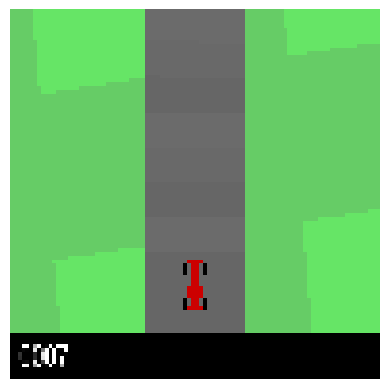

In [8]:
observations, actions = load_imitations("./data/teacher")

# Visualize the first observation
visualize_image(observations[0])

#### Augmentation method 1: Grey Scale

In [9]:
import cv2
import matplotlib.pyplot as plt

def convert_to_grayscale_and_visualize(image_array):
    """
    Convert a given image (numpy array) to grayscale and then visualize it using matplotlib.
    
    Parameters:
    - image_array: numpy array of shape (height, width, channels)
    """
    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    
    # Visualize the grayscale image
    plt.imshow(grayscale_image, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()
    
    return grayscale_image


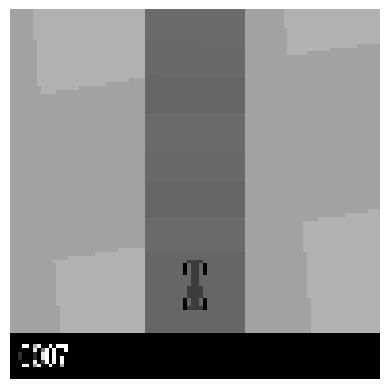

In [11]:
# Assuming you have loaded your observations using the load_imitations function
data_folder = "./data/teacher"
observations, _ = load_imitations(data_folder)

# Convert to grayscale and visualize the first image
grayscale_image = convert_to_grayscale_and_visualize(observations[0])


In [26]:
import os
import cv2
import numpy as np
import shutil

def grayscale_and_save(data_folder, new_directory):
    """
    Convert all observation images in the data_folder to grayscale and save them to a new directory.
    Also, copy the corresponding action files from the original directory to the new directory.
    
    Parameters:
    - data_folder: Path to the folder containing the observation and action files.
    - new_directory: Path to the new directory where grayscale images and action files will be saved.
    """
    
    # Ensure the new directory exists, if not, create it
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    
    # List all files in the data folder
    files = os.listdir(data_folder)
    
    # Filter out observation files
    observation_files = [f for f in files if f.startswith('observation')]
    action_files = [f for f in files if f.startswith('action')]
    
    for filename in observation_files:
        # Load the observation image
        observation_path = os.path.join(data_folder, filename)
        observation_image = np.load(observation_path)
        
        # Convert to grayscale
        grayscale_image = cv2.cvtColor(observation_image, cv2.COLOR_RGB2GRAY)
        
        # Save the grayscale image to the new directory
        new_filename = os.path.join(new_directory, filename)
        np.save(new_filename, grayscale_image)
    
    # Copy action files to the new directory
    action_files = [f for f in files if f.startswith('action')]
    for filename in action_files:
        original_path = os.path.join(data_folder, filename)
        new_path = os.path.join(new_directory, filename)
        shutil.copy2(original_path, new_path)

    print(f"Grayscale images and action files saved to {new_directory}")



In [17]:
import os

grayscale_and_save("./data/teacher", "./data/grey_teacher")

Grayscale images and action files saved to ./data/grey_teacher


#### Data Augmentation Methos 2: Cropping Image

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_cropped_image(image_path):
    """
    Load the image from the given path, crop it to its center 60x60 region, and visualize it.
    
    Parameters:
    - image_path: Path to the image file.
    """
    
    # Load the image
    image = np.load(image_path)
    
    # Get the center coordinates
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    
    # Define the top-left and bottom-right coordinates for cropping
    top_left_x, top_left_y = center_x - 30, center_y - 30
    bottom_right_x, bottom_right_y = center_x + 30, center_y + 30
    
    # Crop the image
    cropped_image = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    
    # Visualize the cropped image
    plt.imshow(cropped_image)
    plt.axis('off')
    plt.show()

# Example usage:
# visualize_cropped_image("path_to_image_file.npy")


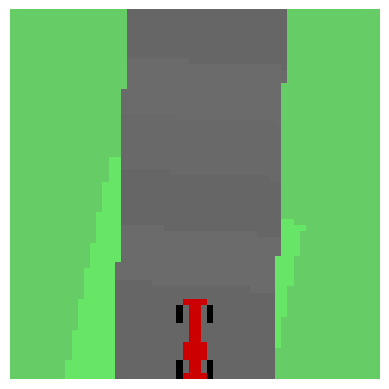

In [24]:
# visualize image
visualize_cropped_image("./data/grey_teacher/observation_00000.npy")

In [28]:
import os
import shutil

def crop_and_save(data_folder, new_directory):
    """
    Crop all observation images in the data_folder to their center 60x60 region and save them to a new directory.
    Also, copy the corresponding action files from the original directory to the new directory.
    
    Parameters:
    - data_folder: Path to the folder containing the observation and action files.
    - new_directory: Path to the new directory where cropped images and action files will be saved.
    """
    
    # Ensure the new directory exists, if not, create it
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    
    # List all files in the data folder
    files = os.listdir(data_folder)
    
    # Filter out observation files
    observation_files = [f for f in files if f.startswith('observation')]
    action_files = [f for f in files if f.startswith('action')]
    
    for filename in observation_files:
        # Load the observation image
        observation_path = os.path.join(data_folder, filename)
        image = np.load(observation_path)
        
        # Get the center coordinates
        center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
        
        # Define the top-left and bottom-right coordinates for cropping
        top_left_x, top_left_y = center_x - 30, center_y - 30
        bottom_right_x, bottom_right_y = center_x + 30, center_y + 30
        
        # Crop the image
        cropped_image = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        
        # Save the cropped image to the new directory
        new_filename = os.path.join(new_directory, filename)
        np.save(new_filename, cropped_image)
    
    # Copy action files to the new directory
    action_files = [f for f in files if f.startswith('action')]
    for filename in action_files:
        original_path = os.path.join(data_folder, filename)
        new_path = os.path.join(new_directory, filename)
        shutil.copy2(original_path, new_path)

    print(f"Cropped images and action files saved to {new_directory}")



In [29]:
crop_and_save("./data/teacher", "./data/cropped_teacher")

Cropped images and action files saved to ./data/cropped_teacher


In [30]:
# view shape of cropped image
observations, _ = load_imitations("./data/cropped_teacher")
print(observations[0].shape)

(60, 60, 3)


In [51]:
# load regret array
regret = np.load("/Users/cheffbcookin/Desktop/518/hw1/data/checkpoints/regrets.npy")

In [52]:
# show regret plot
print(regret.shape)

(25,)


In [53]:
for i in regret:
    print(i)

17.370217438841063
42.99662446402648
93.52003927257383
102.75352536999392
269.59625178318277
538.2762785313022
1075.4326698455354
2146.2992798327987
2191.0579712550198
6509.490923555684
6594.442780433119
19581.236561782076
39222.706980112125
39259.560098421374
117805.48634107407
235460.2389201639
471010.13598002517
471010.13598002517
1412977.2481741619
1413058.5559583353
4239081.985389795
8478124.585498711
8478152.015553774
8478172.239242708
33912591.01753738
